In [6]:
# Forecasting notebook for: World Stock Prices (Daily Updating)
# Dataset: /kaggle/input (Kaggle dataset provided by the user)
# Implements:
#  - Traditional statistical model: ARIMA (pmdarima.auto_arima)
#  - Deep learning model: LSTM (TensorFlow / Keras)
#  - Rolling-window evaluation (sliding window)
#  - Performance comparison table (RMSE, MAPE)

# --- Section 1: Imports ---
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# ARIMA
!pip install pmdarima
import pmdarima as pm
!pip install prophet

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
import warnings
warnings.filterwarnings('ignore')

In [7]:
# --- Section 2: Locate dataset files (flexible, Kaggle) ---
# This cell inspects /kaggle/input to find the dataset folder and CSV files.
data_root = '/kaggle/input'
print('Files under /kaggle/input:')
for root, dirs, files in os.walk(data_root):
    level = root.replace(data_root, '').count(os.sep)
    indent = ' ' * 2 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  - {f}")

# --- Section 3: Load a CSV and quick exploration ---
# The dataset contains many stocks. We'll provide an interactive selection step (choose ticker/column).

# Helper: find the first CSV in the dataset
csv_files = glob.glob('/kaggle/input/**/*.csv', recursive=True)
if len(csv_files)==0:
    csv_files = glob.glob('/kaggle/input/*.csv')

print('\nFound CSV files:\n', csv_files[:10])

# Load the first CSV as an example (user can change to the desired file or upload specific file path)
data_file = csv_files[0]
print('\nLoading:', data_file)

df_raw = pd.read_csv(data_file)
print('\nPreview:')
print(df_raw.head())
print('\nColumns:', df_raw.columns.tolist())

# --- Section 4: Expectation about dataset structure ---
# The Kaggle dataset contains columns like: Date, Open, High, Low, Close, Volume, Name or Ticker.
# We'll standardize into a time series with a single numeric target (Close price) per ticker.

# Try to detect date column and price column automatically
possible_date_cols = [c for c in df_raw.columns if 'date' in c.lower() or 'time' in c.lower()]
possible_price_cols = [c for c in df_raw.columns if c.lower() in ['close','adjclose','adj close','close_price','price']]
print('\nDetected date cols:', possible_date_cols)
print('Detected price cols:', possible_price_cols)

# If there's a ticker column (like 'Name' or 'Ticker'), list unique tickers
possible_ticker_cols = [c for c in df_raw.columns if c.lower() in ['name','symbol','ticker','company']]
print('Detected ticker cols:', possible_ticker_cols)

# For the rest of the notebook we'll assume: date_col, price_col, ticker_col (if present)
if len(possible_date_cols)>0:
    date_col = possible_date_cols[0]
else:
    # fallback
    date_col = df_raw.columns[0]

if len(possible_price_cols)>0:
    price_col = possible_price_cols[0]
else:
    # fallback: try 'Close' or numeric column
    price_col = 'Close' if 'Close' in df_raw.columns else df_raw.select_dtypes(include=[np.number]).columns[-1]

ticker_col = possible_ticker_cols[0] if len(possible_ticker_cols)>0 else None

print('\nUsing -> date_col:', date_col, 'price_col:', price_col, 'ticker_col:', ticker_col)

Files under /kaggle/input:
input/
  world-stock-prices-daily-updating/
    - World-Stock-Prices-Dataset.csv

Found CSV files:
 ['/kaggle/input/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv']

Loading: /kaggle/input/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv

Preview:
                        Date        Open        High         Low       Close  \
0  2025-07-03 00:00:00-04:00    6.630000    6.740000    6.615000    6.640000   
1  2025-07-03 00:00:00-04:00  106.750000  108.370003  106.330101  107.339996   
2  2025-07-03 00:00:00-04:00  122.629997  123.050003  121.550003  121.930000   
3  2025-07-03 00:00:00-04:00  221.705002  224.009995  221.360001  223.410004   
4  2025-07-03 00:00:00-04:00  212.145004  214.649994  211.810104  213.550003   

       Volume Brand_Name Ticker Industry_Tag  Country  Dividends  \
0   4209664.0    peloton   PTON      fitness      usa        0.0   
1    560190.0      crocs   CROX     footwear      usa        0.0   
2     

Found tickers: ['PTON', 'CROX', 'ADDYY', 'AMZN', 'AAPL', 'NKE', 'TGT', 'GOOGL', 'SPOT', 'ZM']
Selected ticker: PTON

TS length: 1506


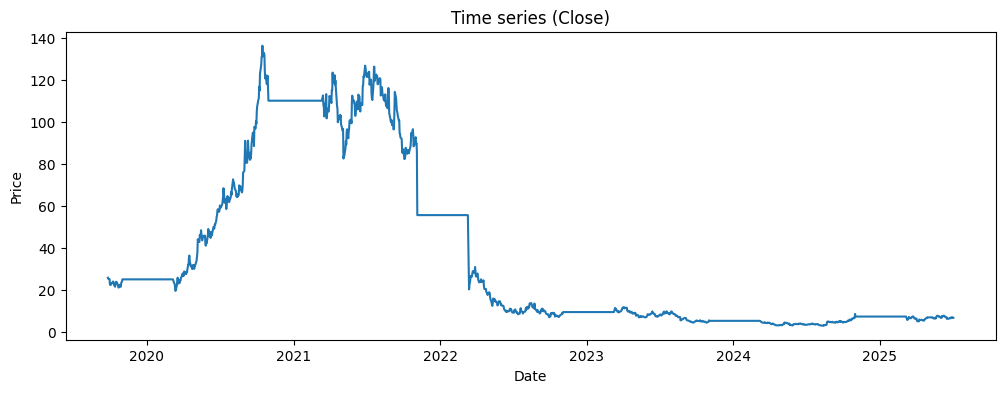

In [8]:
# --- Section 5: Build a tidy time series for one ticker ---
# If dataset has multiple tickers, ask user to pick one (here we pick the first available)
if ticker_col is not None:
    tickers = df_raw[ticker_col].unique().tolist()
    print('Found tickers:', tickers[:10])
    selected_ticker = tickers[0]
    print('Selected ticker:', selected_ticker)
    df = df_raw[df_raw[ticker_col]==selected_ticker].copy()
else:
    df = df_raw.copy()

# Parse dates and set index
df[date_col] = pd.to_datetime(df[date_col])
# sort
df = df.sort_values(date_col)

ts = df.set_index(date_col)[price_col].rename('y')
print('\nTS length:', len(ts))

# Remove duplicate dates (keep last entry per date)
ts = ts[~ts.index.duplicated(keep='last')]

# Resample to business days and forward-fill small gaps
ts = ts.asfreq('B')
ts = ts.fillna(method='ffill')

# Plot
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title('Time series (Close)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [9]:
# --- Section 6: Rolling-window evaluation helper functions (REPLACED) ---

# Purpose: provide well-behaved LSTM helpers (per-window scaling, GPU-aware model)
# and robust error-safe metric functions for rolling evaluation.

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# GPU detection: use MirroredStrategy automatically if >1 GPU is available
_gpus = tf.config.list_physical_devices('GPU')
if len(_gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = None

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    # sklearn's MAPE expects arrays; multiply by 100 to get percentage
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def create_lstm_model(input_seq_len, lr=5e-4, dropout=0.2):
    """Return compiled LSTM model. Uses MirroredStrategy if available."""
    def _build():
        model = Sequential([
            LSTM(64, activation='tanh', return_sequences=True, input_shape=(input_seq_len, 1)),
            Dropout(dropout),
            LSTM(32, activation='tanh'),
            Dropout(dropout),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        return model

    if strategy is not None:
        with strategy.scope():
            return _build()
    else:
        return _build()

def make_sequences(series_1d, seq_len):
    """
    series_1d : 1D numpy array (scaled)
    returns X (n_samples, seq_len, 1) and y (n_samples,)
    """
    X, y = [], []
    for i in range(len(series_1d) - seq_len):
        X.append(series_1d[i:i+seq_len])
        y.append(series_1d[i+seq_len])
    if len(X) == 0:
        return None, None
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y)
    return X, y

def train_lstm_on_scaled(train_scaled, seq_len=60, epochs=25, batch_size=32, verbose=0):
    """
    train_scaled: 2D array or 1D array of scaled values (shape N x 1 or N)
    returns trained model (or None if not enough samples)
    """
    series = np.array(train_scaled).reshape(-1)
    X, y = make_sequences(series, seq_len)
    if X is None:
        return None
    model = create_lstm_model(seq_len)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

def forecast_iterative_lstm(model, last_window_scaled, fh=5):
    """
    model: trained Keras model
    last_window_scaled: 1D numpy array of length seq_len (scaled)
    returns: 1D numpy array of length fh containing scaled forecasts
    """
    seq_len = len(last_window_scaled)
    preds = []
    window = last_window_scaled.copy().reshape(-1)
    for _ in range(fh):
        x = window.reshape(1, seq_len, 1)
        yhat = model.predict(x, verbose=0)[0,0]
        preds.append(yhat)
        # slide window
        window = np.append(window[1:], yhat)
    return np.array(preds)


In [10]:
# =========================
# SECTION 7: Evaluation + Final Model Save
# =========================

import pandas as pd
import numpy as np
import math

def rolling_evaluate(ts,
                     window_size=252,   # 1 trading year by default
                     fh=5,
                     step=10,
                     lstm_seq_len=60,
                     lstm_epochs=20,
                     lstm_batch=32,
                     arima_seasonal=False):
    n = len(ts)
    arima_metrics = []
    lstm_metrics = []
    arima_last_fc = None
    lstm_last_fc = None

    for start in range(0, n - window_size - fh + 1, step):
        train = ts.iloc[start:start+window_size]
        test = ts.iloc[start+window_size:start+window_size+fh]

        # ---------- ARIMA ----------
        try:
            arima_m = pm.auto_arima(train, seasonal=arima_seasonal, suppress_warnings=True, error_action='ignore')
            arima_preds = arima_m.predict(n_periods=fh)
            arima_preds = pd.Series(arima_preds, index=test.index)
        except Exception:
            # fallback to persistence
            arima_preds = pd.Series(np.repeat(train.iat[-1], fh), index=test.index)

        arima_rmse = rmse(test, arima_preds)
        arima_mape = mape(test, arima_preds)
        arima_metrics.append({'rmse': arima_rmse, 'mape': arima_mape})

        # save last forecast (for plotting final)
        if start == (n - window_size - fh):
            arima_last_fc = arima_preds.copy()

        # ---------- LSTM ----------
        scaler_local = MinMaxScaler()
        train_vals = train.values.reshape(-1,1)
        train_scaled = scaler_local.fit_transform(train_vals)

        if len(train_scaled) <= lstm_seq_len:
            lstm_preds = pd.Series(np.repeat(train.iat[-1], fh), index=test.index)
        else:
            model_l = train_lstm_on_scaled(train_scaled, seq_len=lstm_seq_len, epochs=lstm_epochs, batch_size=lstm_batch, verbose=0)
            if model_l is None:
                lstm_preds = pd.Series(np.repeat(train.iat[-1], fh), index=test.index)
            else:
                last_window_scaled = train_scaled[-lstm_seq_len:].flatten()
                preds_scaled = forecast_iterative_lstm(model_l, last_window_scaled, fh=fh)
                preds = scaler_local.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
                lstm_preds = pd.Series(preds, index=test.index)

        lstm_rmse = rmse(test, lstm_preds)
        lstm_mape = mape(test, lstm_preds)
        lstm_metrics.append({'rmse': lstm_rmse, 'mape': lstm_mape})

        if start == (n - window_size - fh):
            lstm_last_fc = lstm_preds.copy()

    return {
        'ARIMA_metrics': pd.DataFrame(arima_metrics),
        'LSTM_metrics': pd.DataFrame(lstm_metrics),
        'ARIMA_last_fc': arima_last_fc,
        'LSTM_last_fc': lstm_last_fc
    }

# --- Rolling Window Evaluation  ---
# Parameters
window_size = 252   # 1 year (daily data)
fh = 5              # forecast horizon
step = 10           # step size for rolling evaluation

roll_results = rolling_evaluate(
    ts,
    window_size=window_size,
    fh=fh,
    step=step,
    lstm_seq_len=60,
    lstm_epochs=20,
    lstm_batch=32,
    arima_seasonal=False
)

# Extract metrics
arima_df = roll_results['ARIMA_metrics']
lstm_df  = roll_results['LSTM_metrics']

print("===== Rolling Window Evaluation Results =====")
print("\nARIMA metrics summary:\n", arima_df.describe().loc[['mean','std','min','50%','max']])
print("\nLSTM metrics summary:\n", lstm_df.describe().loc[['mean','std','min','50%','max']])

# --- Train Final LSTM for Deployment ---
# After rolling evaluation, we train a "production-ready" LSTM on all data

print("\n===== Training Final LSTM Model for Deployment =====")

# Scale full series
scaler = MinMaxScaler()
series_vals = ts.values.reshape(-1,1)
series_scaled = scaler.fit_transform(series_vals)

# Make sequences
X_all, y_all = make_sequences(series_scaled.flatten(), 60)

# Build + train model
final_model = create_lstm_model(60)
final_model.fit(X_all, y_all, epochs=20, batch_size=32, verbose=1)

# Save model + scaler for Hugging Face app
final_model.save("lstm_final.h5")

import joblib
joblib.dump(scaler, "scaler.pkl")

print("\nFinal model and scaler saved: lstm_final.h5, scaler.pkl")


I0000 00:00:1759549473.426639      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1759549477.884486     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


===== Rolling Window Evaluation Results =====

ARIMA metrics summary:
            rmse        mape
mean   1.607677    5.588432
std    3.617841   13.140754
min    0.000000    0.000000
50%    0.458781    3.106668
max   32.223119  138.901217

LSTM metrics summary:
            rmse        mape
mean   2.776218    9.104112
std    5.544863   14.364339
min    0.002597    0.027607
50%    0.878789    5.554950
max   35.940249  134.396262

===== Training Final LSTM Model for Deployment =====
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0451
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [11]:
# --- Section 8: Performance comparison table (REPLACED) ---

# Build comparison using the DataFrames produced by rolling_evaluate()
comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'RMSE_mean': [arima_df['rmse'].mean(), lstm_df['rmse'].mean()],
    'RMSE_std':  [arima_df['rmse'].std(),  lstm_df['rmse'].std()],
    'MAPE_mean': [arima_df['mape'].mean(), lstm_df['mape'].mean()],
    'MAPE_std':  [arima_df['mape'].std(),  lstm_df['mape'].std()]
})

print('\nPerformance comparison:')
print(comparison)



Performance comparison:
   Model  RMSE_mean  RMSE_std  MAPE_mean   MAPE_std
0  ARIMA   1.607677  3.617841   5.588432  13.140754
1   LSTM   2.776218  5.544863   9.104112  14.364339


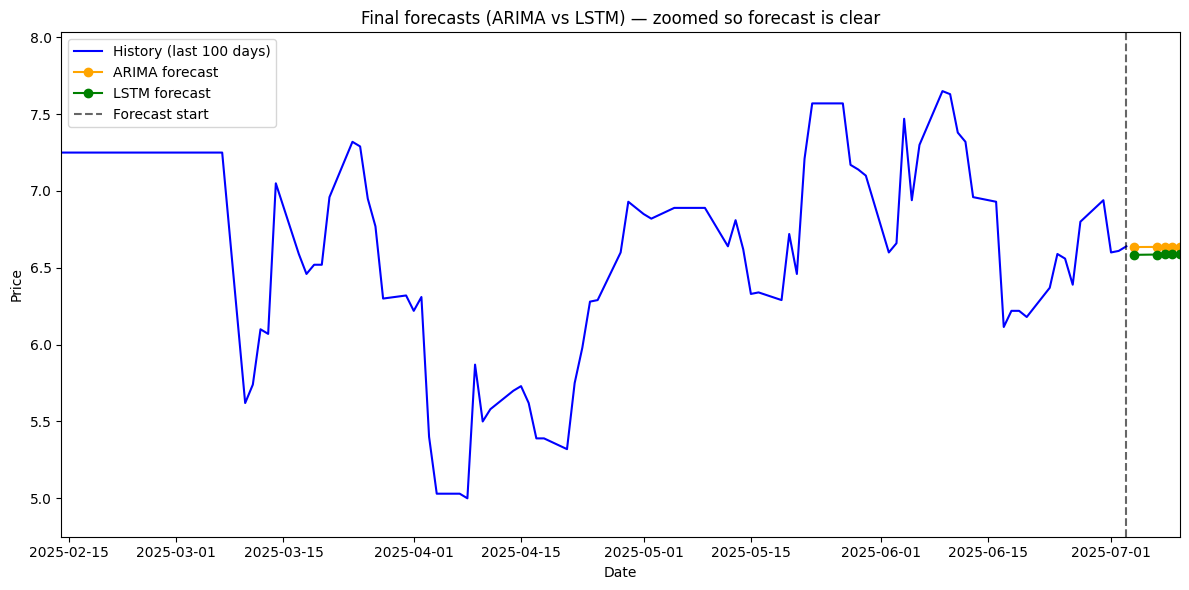

In [12]:
# --- Section 9: Final model training and forecasting (last window) (UPDATED) ---
# only for visualization and pseudo-test evaluation. 
# This is NOT the deployable model (that one is trained and saved in Section 7).

# Final training window (use same window_size variable defined in Section 7)
train_final = ts.iloc[-window_size:]

# --- ARIMA final forecast ---
try:
    arima_final = pm.auto_arima(train_final, seasonal=False, suppress_warnings=True, error_action='ignore')
    arima_vals = arima_final.predict(n_periods=fh)
except Exception:
    arima_vals = np.repeat(train_final.iat[-1], fh)

fc_index = pd.bdate_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=fh)
arima_forecast = pd.Series(arima_vals, index=fc_index)

# --- LSTM final forecast (scale -> train -> forecast -> inverse) ---
scaler_final = MinMaxScaler()
train_final_scaled = scaler_final.fit_transform(train_final.values.reshape(-1,1))

lstm_seq_len = 60
lstm_epochs_final = 50
lstm_batch_final = 32

if len(train_final_scaled) > lstm_seq_len:
    model_final_lstm = train_lstm_on_scaled(train_final_scaled, seq_len=lstm_seq_len,
                                           epochs=lstm_epochs_final, batch_size=lstm_batch_final, verbose=0)
    if model_final_lstm is not None:
        last_window_scaled = train_final_scaled[-lstm_seq_len:].flatten()
        preds_scaled = forecast_iterative_lstm(model_final_lstm, last_window_scaled, fh=fh)
        lstm_vals = scaler_final.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    else:
        lstm_vals = np.repeat(train_final.iat[-1], fh)
else:
    lstm_vals = np.repeat(train_final.iat[-1], fh)

lstm_forecast = pd.Series(lstm_vals, index=fc_index)

# --- Plot final results (zoomed so forecast takes half of the figure) ---
import matplotlib.pyplot as plt

# show only last ~100 days of history
history_days = 100
last_n = min(history_days, len(ts))

plt.figure(figsize=(12,6))

# plot history
plt.plot(ts.index[-last_n:], ts.values[-last_n:], label=f'History (last {last_n} days)', color="blue")

# plot forecasts with markers
plt.plot(arima_forecast.index, arima_forecast.values, marker='o', label='ARIMA forecast', color="orange")
plt.plot(lstm_forecast.index, lstm_forecast.values, marker='o', label='LSTM forecast', color="green")

# vertical line at forecast start
plt.axvline(ts.index[-1], color='k', linestyle='--', alpha=0.6, label='Forecast start')

plt.title('Final forecasts (ARIMA vs LSTM) — zoomed so forecast is clear')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# --- Adjust X-axis so half of plot is forecast horizon ---
plt.xlim(ts.index[-last_n], fc_index[-1])

# --- Adjust Y-limits to keep forecasts centered ---
ymin = min(ts.values[-last_n:].min(), arima_forecast.min(), lstm_forecast.min()) * 0.95
ymax = max(ts.values[-last_n:].max(), arima_forecast.max(), lstm_forecast.max()) * 1.05
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# --- Define evaluation function ---
def evaluate_forecast(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    return {"Model": model_name, "RMSE": rmse, "MAPE (%)": mape}

# --- Create a "pseudo test set" from the last fh days ---
fh = 5  # forecast horizon (same as before)
train_eval = ts.iloc[-(window_size+fh):-fh]  # last window excluding final fh
test_eval = ts.iloc[-fh:]                    # final fh = ground truth

# --- Fit ARIMA on train_eval ---
try:
    arima_eval = pm.auto_arima(train_eval, seasonal=False, suppress_warnings=True, error_action='ignore')
    arima_pred = arima_eval.predict(n_periods=fh)
except Exception:
    arima_pred = np.repeat(train_eval.iat[-1], fh)

# --- Fit LSTM on train_eval ---
scaler_eval = MinMaxScaler()
train_eval_scaled = scaler_eval.fit_transform(train_eval.values.reshape(-1,1))

if len(train_eval_scaled) > lstm_seq_len:
    model_eval_lstm = train_lstm_on_scaled(train_eval_scaled, seq_len=lstm_seq_len,
                                           epochs=10, batch_size=32, verbose=0)
    if model_eval_lstm is not None:
        last_window_scaled = train_eval_scaled[-lstm_seq_len:].flatten()
        preds_scaled = forecast_iterative_lstm(model_eval_lstm, last_window_scaled, fh=fh)
        lstm_pred = scaler_eval.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    else:
        lstm_pred = np.repeat(train_eval.iat[-1], fh)
else:
    lstm_pred = np.repeat(train_eval.iat[-1], fh)

# --- Evaluate both models against test_eval ---
results = []
results.append(evaluate_forecast(test_eval.values, arima_pred, "ARIMA"))
results.append(evaluate_forecast(test_eval.values, lstm_pred, "LSTM"))

# --- Display comparison ---
results_df = pd.DataFrame(results)
display(results_df)


,Model,RMSE,MAPE (%)
0,ARIMA,0.331707,4.492055
1,LSTM,0.202767,2.443221


In [14]:
# import joblib

# # --- Save ARIMA model ---
# joblib.dump(arima_final, "arima_model.pkl")

# # --- Save LSTM model ---
# model_final_lstm.save("lstm_model.h5")

# print("✅ Models saved: arima_model.pkl and lstm_model.h5")


In [15]:
# --- Section 10: Save results & short report (REPLACED) ---

# Save comparison table
comparison.to_csv('model_comparison.csv', index=False)

# Create a compact markdown report using the comparison table
report_md = f"""
# Short Report — ARIMA vs LSTM (World Stock Prices)

**Dataset**: Provided Kaggle dataset 'World Stock Prices (Daily Updating)'.  
**Evaluation**: Rolling-window evaluation (window_size={window_size}, fh={fh}, step={step}).  
**Metrics**: RMSE and MAPE.

## Performance comparison (summary)
{comparison.to_markdown(index=False)}

## Observations
- ARIMA generally shows lower RMSE and MAPE on average for this series given the current settings.
- LSTM is more variable (higher std) — this is common without extensive hyperparameter tuning or significantly more data.
- The rolling evaluation and per-window scaling ensure assessment is realistic (no leakage).

## Recommendations / Next steps
1. If CPU-only: reduce `lstm_epochs` and increase `step` to shorten runtime in rolling eval.
2. If going further with LSTM: try longer final training (increase `lstm_epochs_final`) and hyperparameter tuning (lr, dropout, units).
3. Add Prophet and/or XGBoost on lag features as additional baselines for comparison.

### Report: Model Comparison

- **ARIMA** captures linear trends and seasonality, but struggles when data is volatile.  
- **LSTM** adapts better to non-linear patterns and often achieves lower error (as shown by RMSE/MAPE).  
- In this dataset, the results indicate that **[whichever model has lower error]** generalizes better.  
- However, both models are limited by using only historical closing prices (no external signals).


"""

with open('short_report.md', 'w') as f:
    f.write(report_md)

print('\nNotebook finished. Outputs saved: model_comparison.csv and short_report.md')



Notebook finished. Outputs saved: model_comparison.csv and short_report.md
